# ChemSpaceSampler

- How many molecules can be found in chemical space as a function of representation distance (from a point in chemical space)?
- Does this number correlate with machine learning molecular properties?
- Is it possible to predict the density of molecules (in chemical space) around a query molecule? **SPOILER: YES it is!!!**
- I study this using Konstantin's MC code and will try to link the prediction error for a molecule to the number of molecules around a central molecule in chemical space (work in progress)

First example: distaces between representation of molecules
- Use RDKit to generate ECFP4 representations of molecules $X_1, X_2$
- Distance between two molecules defined as $d = ||X_1 - X_2||_2$

In [4]:
#First we import some libraries that we will use in this tutorial
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import rdkit
from sklearn.decomposition import PCA
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit import Chem

try:
    from rdkit.Chem import RDConfig
    sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
    import sascorer
    from scipy.stats import binned_statistic_2d
except:
    print("WARNING: Failed to import sascorer. Check you rdkit verion!")
    
from rdkit.Chem import Draw

fs = 12
plt.rc("font", size=fs)
plt.rc("axes", titlesize=fs)
plt.rc("axes", labelsize=fs)
plt.rc("xtick", labelsize=fs)
plt.rc("ytick", labelsize=fs)
plt.rc("legend", fontsize=fs)
plt.rc("figure", titlesize=fs)

def make_pretty(axi):
    """
    Method to make the axes look pretty
    """
    axi.spines["right"].set_color("none")
    axi.spines["top"].set_color("none")
    axi.spines["bottom"].set_position(("axes", -0.05))
    axi.spines["bottom"].set_color("black")
    axi.spines["left"].set_color("black")
    axi.yaxis.set_ticks_position("left")
    axi.xaxis.set_ticks_position("bottom")
    axi.spines["left"].set_position(("axes", -0.05))
    return axi 

# Potential functions in chemical space

Next we define a potential that we will use to probe chemical space at a given target distance $d$. For the example given below we would be sampling molecules at distance between $d=2$ and $d=4$. For convinience we define a function that returns the potential above where $\epsilon=1.0$ controlls the depth of the potential and $\gamma$ and $\sigma$ the left and right position of the flat minimas.
As you will notice the depth has no influence on the sampled molecules, but by 

By setting $\gamma = 0.0$ and $\sigma = 1.5$ we sample all molecules at a maximal distance of 1.5 from the initial molecule. However, we can also sample specific distance intervals by setting $\gamma$ and $\sigma$ to the desired values. The potential is defined as

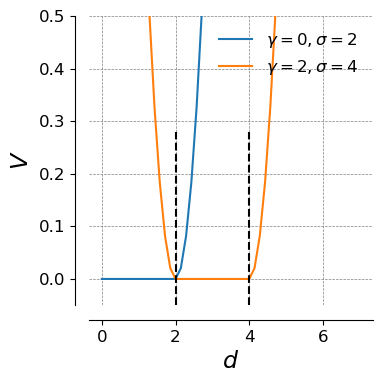

In [6]:
def flat_parabola_potential(d, gamma, sigma):
    """
    Flat parabola potential. Allows sampling within a distance basin
    interval of I in [gamma, sigma]. epsilon determines depth of minima
    and is typically set to epsilon = 5. The potential is given by:
    """
    if d < gamma:
        return (d - gamma) ** 2
    if gamma <= d <= sigma:
        return 0
    if d > sigma:
        return (d - sigma) ** 2 


epsilon = 0
gamma1,sigma1 = 0, 2.0
gamma2,sigma2 = 2, 4



fig1, ax1 = plt.subplots(figsize=(4,4))

dist = np.linspace(0,7)
y1 = [flat_parabola_potential(dval, gamma1, sigma1) for dval in dist]
y2 = [flat_parabola_potential(dval, gamma2, sigma2) for dval in dist]
ax1.grid(True, linestyle='--', linewidth=0.5, color='grey')

ax1.plot(dist, y1, label = r"$\gamma = 0, \sigma = 2$")
ax1.plot(dist, y2, label = r"$\gamma = 2, \sigma = 4$")
ax1.set_ylim(-0.05, 0.5)
ax1.axvline(x=2, ymin=0, ymax=0.6,color="black", linestyle="--")
ax1.axvline(x=4, ymin=0, ymax=0.6,color="black", linestyle="--")
make_pretty(ax1)


plt.xlabel('$d$', fontsize = fs+5)
plt.ylabel('$V$', fontsize = fs+5)
#make the plot look nice and tight
#add legend
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

Now we sample molecules in shells around the central molecule! 
First, we define a dictionary that contains a number of parameters:

- `min_d` is equal to $\gamma$, `max_d` is equal to $\sigma$
- `V_0_pot` is equals $\epsilon$
- `strictly_in`: If true, only return molecules strictly in the interval defined above, else return all sampled molecules
- `V_0_synth` regulates importance is respecting synthezisability potential constraint
- `synth_cut_soft`, `synth_cut_hard` soft/hard cutoff for synthezisability score (explained below, ignore for now!)
- `NPAR` Number of cores for parallel execution of MC
- `Nsteps` Number of MC steps (per execution)
- `bias_strenght` potential driving each replica into previously unvisited parts of chemical space
- `possible_elements` elements allowed for trial moves
- `not_protonated` elements that will not be protonated
- `forbidden_bonds` bond combinations that are not allowed
- `nhatoms_range` range of allowed heavy atoms, here we look at fixed 13 heavy atoms only
- `betas` array of inverse temperatures i.e. $\beta_i$ values, generated with a custom function
- `make_restart_frequency` every n step a restart file is generated, not needed here
- `rep_type` type of representation, here 





As you change the smiles string, the 2D representation of the molecule changes. By that you also increase or decrease the distance `d` between the molecules.



In [8]:
from mosaics.minimized_functions import chemspace_potentials
from mosaics.beta_choice import gen_exp_beta_array

params = {
    'min_d': 1.0,
    'max_d': 5.0,
    'V_0_pot': 1,
    'strictly_in': True,
    'V_0_synth': 0.05,
    'synth_cut_soft':10,
    'synth_cut_hard':10,
    'NPAR': 1,
    'Nsteps': 5,
    'bias_strength': "none",
    'possible_elements': ["C", "O", "N", "F"],
    'not_protonated': [5, 9, 14, 15, 16, 17, 35], 
    'forbidden_bonds': [(8, 9), (8, 8), (9, 9), (7, 7)],
    'nhatoms_range': [13, 13],
    'betas': gen_exp_beta_array(4, 1.0, 32, max_real_beta=8.0),
    'make_restart_frequency': None,
    "rep_type": "2d",
    "nBits": 2048,
    'rep_name': 'ECFP',
    'mmff_check': True, 
    "verbose": False}

aspirin = "CC(=O)OC1=CC=CC=C1C(=O)O"
MOLS, D = chemspace_potentials.chemspacesampler_ECFP(smiles=aspirin, params=params)    

Let's look at the molecules we found and their actualy distances to aspirin

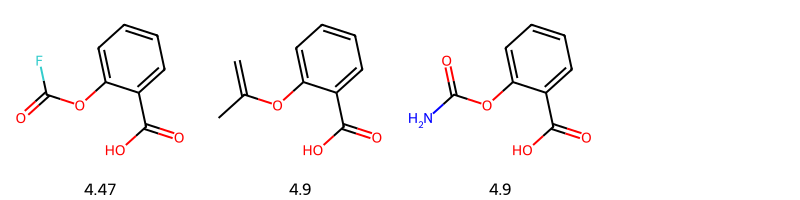

In [9]:
rdkit_mols = [Chem.MolFromSmiles(smiles) for smiles in MOLS]
img = Draw.MolsToGridImage(rdkit_mols, molsPerRow=4, subImgSize=(200, 200), legends=[str(round(d, 2)) for d in D])
display(img)

As expected all these molecules are within the predefined interval.
Now redo the same simulation but try to find the clostest and farthest molecule possible for aspirin!
Hint: Modify the params dictionary to sample at larger distances!

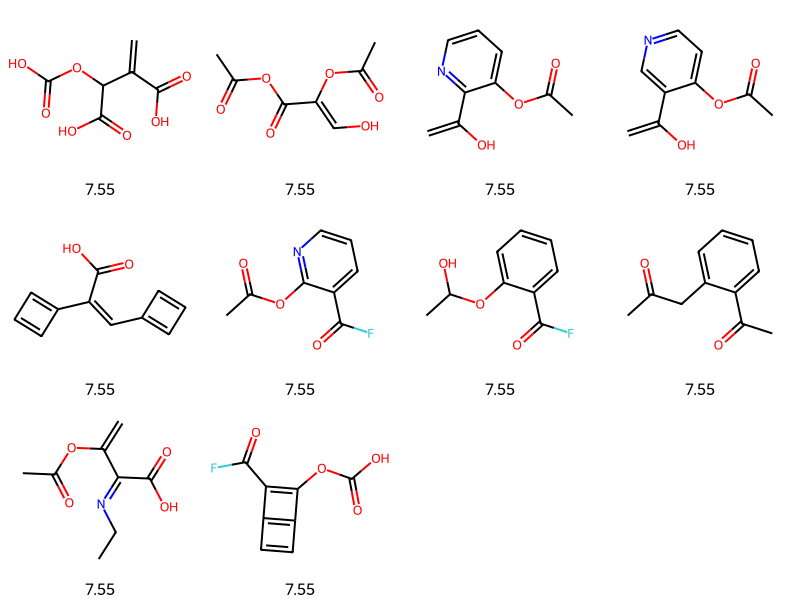

In [19]:
params['min_d'],params['max_d']   = 7.5, 20.0
MOLS, D = chemspace_potentials.chemspacesampler_ECFP(smiles=aspirin, params=params)    
rdkit_mols = [Chem.MolFromSmiles(smiles) for smiles in MOLS]
img = Draw.MolsToGridImage(rdkit_mols[:10], molsPerRow=4, subImgSize=(200, 200), legends=[str(round(d, 2)) for d in D[:10]])
display(img)

We did not talk about the synthezisability of the generated molecules. 
In fact there is a simple function to control that:
The `scscore` from rdkit assignes a score from 1 = easy to make to 10=impossible
to each molecule. We use this score to define a potential that guides molecule
generation towards lower i.e. more realistic mocules.
The score is added to the other potential functions.

In [20]:
# Control Synthezizability

def synth_potential(self, score):
    if score > self.synth_cut_hard:
        return None
    if score > self.synth_cut_soft:
        return self.V_0_synth * (score - self.synth_cut_soft) ** 2
    else:
        return 0


Previously we set both cutoff values to 10 so we did'nt account for the Synthezizability.
Now we investigate the effect of it, repeat the same experiment sampling at a lage distance,but
with a lower cutoff for the synthezisability!

/home/jan/miniconda3/envs/fuck/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


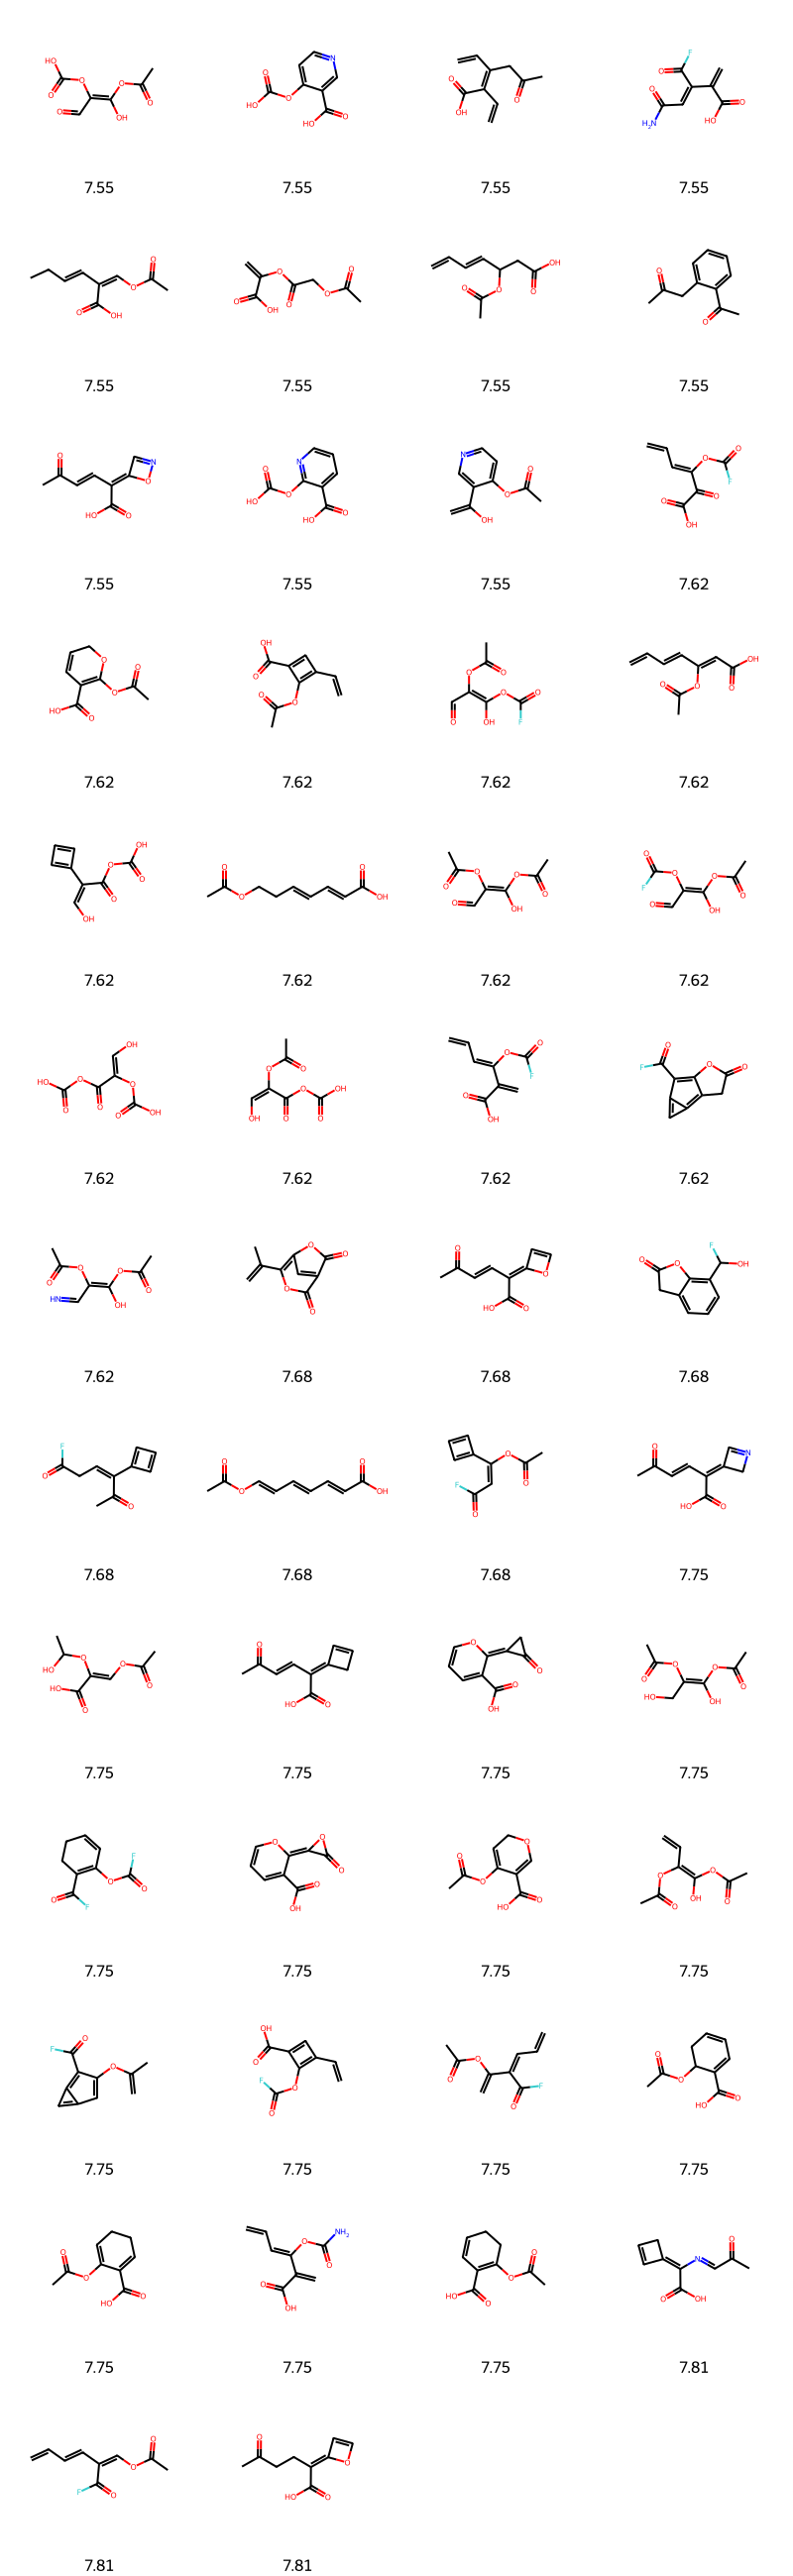

In [22]:
params['min_d'], params['max_d'] = 7.5, 200.0
params['NPAR'] = 4
params['synth_cut_soft'], params['synth_cut_hard'] = 4, 5

MOLS, D = chemspace_potentials.chemspacesampler_ECFP(smiles=aspirin, params=params)  
rdkit_mols = [Chem.MolFromSmiles(smiles) for smiles in MOLS]
img = Draw.MolsToGridImage(rdkit_mols, molsPerRow=4, subImgSize=(200, 200), legends=[str(round(d, 2)) for d in D])
display(img)  

Next, we are interested in a larger picture of the chemical space sampled. Therefore, we
allow a large interval of molecules to be accepted (while keeping the synth to a reasable value)

In [29]:
params['min_d'], params['max_d'] = 0, 200.0
params['NPAR'] = 4
params['synth_cut_soft'], params['synth_cut_hard'] = 7, 8
params['strictly_in'] = False


MOLS, D = chemspace_potentials.chemspacesampler_ECFP(smiles=aspirin, params=params)    

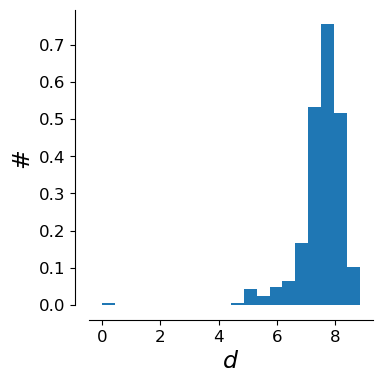

In [30]:
#create a histogram of the distances
fig, ax = plt.subplots(figsize=(4,4))
ax.hist(D, bins=20, density=True)
ax.set_xlabel('$d$', fontsize = fs+5)
ax.set_ylabel('#', fontsize = fs+5)
make_pretty(ax)
plt.tight_layout()


Now we visualize the results. We plot a PCA projection of the sampled molecules and color them by the distance to the initial molecule. 

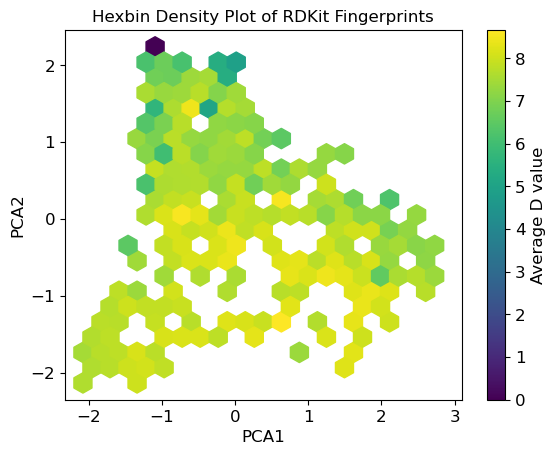

In [31]:
fps = []
for smiles in MOLS:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        arr = np.zeros((1,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        fps.append(arr)

fps = np.array(fps)

# Perform PCA
pca = PCA(n_components=2)
reduced_fps = pca.fit_transform(fps)


x, y = reduced_fps[:, 0], reduced_fps[:, 1]
cmap = plt.cm.viridis

# Calculate the average D value for each hexbin
statistic, x_edge, y_edge, bin_number = binned_statistic_2d(x, y, D, statistic='mean', bins=[10, 10])

plt.hexbin(x, y, C=D, gridsize=20, cmap=cmap, reduce_C_function=np.mean)
cb = plt.colorbar()
cb.set_label('Average D value')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Hexbin Density Plot of RDKit Fingerprints')
plt.show()

As you can see the PCA reflects well the distance of the sampled molecules. at `D=0` we have aspirin